# SET UP

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import math

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'



# Feature Engineering

In [2]:
hydro = pd.read_csv('station_data.csv')
hydro['Water Level_previous'] = hydro["Value"].shift(1) 
hydro['WL_pct'] = 100*(hydro["Value"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)

In [3]:
hydro.head()

,Date,ID,PARAM,Value,Latitude,Longitude,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Precip,Water Level_previous,WL_pct
1,2000-01-03,08MG012,2,9.188,49.30926,-121.77373,2.2,-1.1,0.6,17.4,0.0,9.0,9.209,-0.228038
2,2000-01-04,08MG012,2,9.175,49.30926,-121.77373,9.1,0.9,5.0,13.0,0.0,10.8,9.188,-0.141489
3,2000-01-05,08MG012,2,9.158,49.30926,-121.77373,7.5,1.6,4.6,13.4,0.0,0.0,9.175,-0.185286
4,2000-01-06,08MG012,2,9.142,49.30926,-121.77373,3.8,0.9,2.4,15.6,0.0,7.8,9.158,-0.174711
5,2000-01-07,08MG012,2,9.121,49.30926,-121.77373,6.6,1.7,4.2,13.8,0.0,4.0,9.142,-0.229709


<AxesSubplot:>

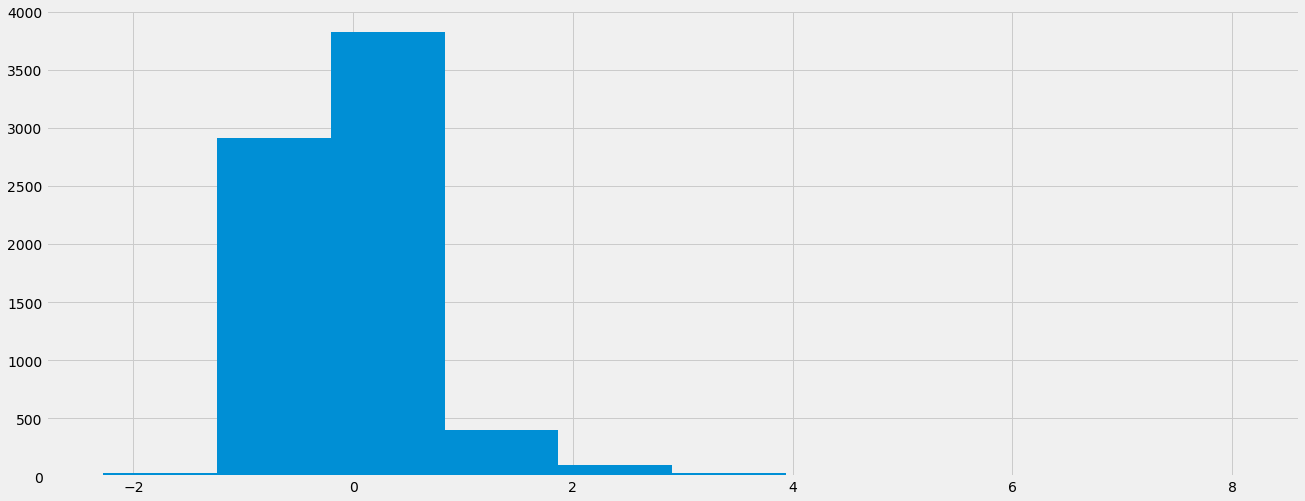

In [4]:
hydro.WL_pct.hist()

In [5]:
hydro['anomaly']  = (hydro['WL_pct']>0.2).astype(int)

## Statistical Features 

In [6]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro['acc_precip_week'] = hydro['Total Precip'].rolling(7).sum()
hydro['acc_precip_2weeks'] =  hydro['Total Precip'].rolling(14).sum()
hydro['std_precip_2weeks'] =  hydro['Total Precip'].rolling(7).std()

hydro.dropna(inplace = True )

In [7]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6','acc_precip_week','acc_precip_2weeks','std_precip_2weeks','Total Precip' , 'Mean Temp' ]

## Time Based Features 

In [8]:
hydro['Date'] = pd.to_datetime(hydro['Date'])
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek
hydro['month'] =  hydro['Date'].dt.month

In [9]:
cat_feat = ['hour','dayOfweek','month']

In [10]:
embbedded_size  = [(24,12),(7,4),(12,6)]

# Modling Part 

In [11]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Extreme Value Loss

In [14]:
class EVL() : 
    def __init__(self , alpha , thershold) : 
        self.alpha = alpha 
        self.threshold = threshold 
        self.MSE = nn.MSELoss() 
        
    def __call__(self , y_pred , y_true) :  
        loss = self.MSE(y_pred , y_true) 
        above_threshold = (y_true >= self.thershold).type(torch.float) 
        outliers_loss = self.MSE(
                    y_true[(above_threshold != 0).nonzero(as_tuple=True)],
                    y_pred[(above_threshold != 0).nonzero(as_tuple=True)],
                )
        final_loss = loss + self.alpha * outliers_loss 
        
        return final_loss 

## Stacked LSTM 

In [13]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cpu')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

'val_loss, train_loss = run(\n    stacked_lstm,\n    train_dataset,\n    valid_dataset,\n    lr,\n    epochs,\n    train_batch_size,\n    valid_batch_size,\n    device,\n    path,\n    verbose , \n    is_forcaster = True \n)'

# Auto Encoder + LSTM Stacked 

In [16]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 200
input_size = len(num_feat)
hidden_size = 64
lr = 3e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Autoencoder.pth'
verbose = False
emb_size = 24

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

autoencoder_lstm = LSTMAutoEncoder(input_size = input_size ,hidden_size = hidden_size,emb_size= emb_size )
autoencoder_lstm = autoencoder_lstm.to(device)

val_loss, train_loss = run(
    autoencoder_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True , 
    is_added_auto_encoder = True,
)

--------- Epoch 0 ---------
 train_loss  = 0.859660423391468
 val_loss  = 0.003883689940347621
--------- Epoch 10 ---------
 train_loss  = 0.8358484771880474
 val_loss  = 0.003727501378549884
--------- Epoch 20 ---------
 train_loss  = 0.8312401339247987
 val_loss  = 0.0011638611070844086
--------- Epoch 30 ---------
 train_loss  = 0.830252970640476
 val_loss  = 0.0010333259484064507
--------- Epoch 40 ---------
 train_loss  = 0.8304533529412615
 val_loss  = 0.0009170487597051154
--------- Epoch 50 ---------
 train_loss  = 0.8297371949468341
 val_loss  = 0.0009145418735392418
Eraly Stopping on Epoch 50
Best Loss =  0.0009126909917944835


## Evaluation 

In [17]:
val_data.set_index('Date' , inplace =True)

In [18]:
val_data = val_data.iloc[window_size:]

100%|██████████| 23/23 [00:00<00:00, 78.41it/s]


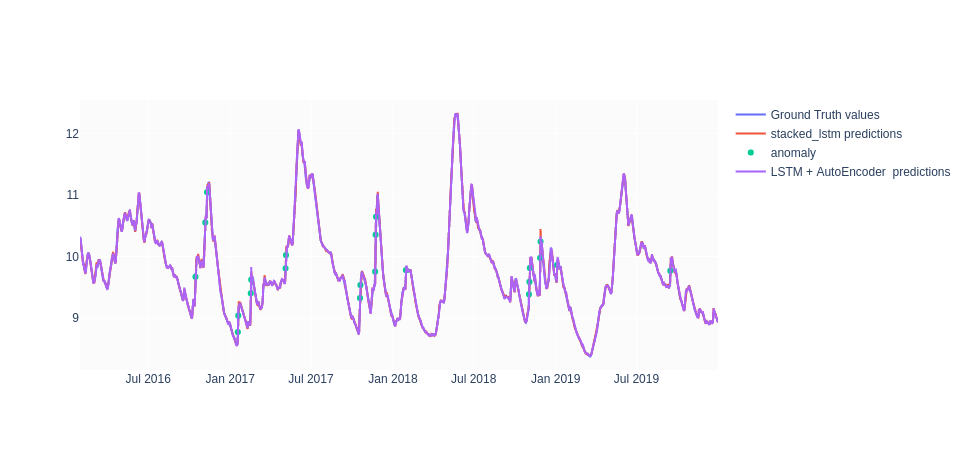

In [19]:

pred = predict( stacked_lstm , valid_dataset)
val_data['WL_pct_hat_stacked'] = pred / 10
val_data['WL_hat_stacked_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat_stacked'] )

pred = predict( autoencoder_lstm , valid_dataset ,is_added_auto_encoder = True )
val_data['WL_pct_hat_autoencoder'] = pred / 10
val_data['WL_hat_autoencoder_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat_autoencoder'] )
a = val_data.loc[val_data['anomaly'] == 1, ['Value']] #anomaly

fig = make_subplots()
fig.add_trace(go.Scatter(x = val_data.index ,  y=val_data['Value'].values, name='Ground Truth values'))
fig.add_trace(go.Scatter(x = val_data.index ,  y=val_data['WL_hat_stacked_lstm'].values ,name='stacked_lstm predictions'))
fig.add_trace(go.Scatter( x = a.index , y=a['Value'].values ,name='anomaly', mode='markers'))
fig.add_trace(go.Scatter( x = val_data.index ,y=val_data['WL_hat_autoencoder_lstm'].values ,name='LSTM + AutoEncoder  predictions'))


fig.show()

In [20]:
print('LSTM Stacked Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('R2 = ', r2_score(val_data['Value'], val_data['WL_hat_stacked_lstm']))

LSTM Stacked Model Results
MSE =  0.0009033767016611373
RMSE =  0.030056225672248624
mean_absolute_error =  0.017254809394645337
R2 =  0.9983260165950089


In [21]:
print('LSTM + AutoEncoder Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('R2 = ', r2_score(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))

LSTM + AutoEncoder Model Results
MSE =  0.0008559484386149939
RMSE =  0.02925659649745667
mean_absolute_error =  0.016819387827630473
R2 =  0.9984139025512448
